# Exploring MTA Ridership in New York City during COVID-19 Pandemic

For this project, my goal was to see the impact of COVID-19 Pandemic on New York City's MTA ridership. The main chunk of this project will be analyzing ridership levels pre-COVID and during COVID. I will also be taking New York City's neighborhood's property value status into consideration to see how certain neighborhoods affected ridership levels.

## Approach

Growing up in Brooklyn, riding the MTA was my main source of commute. Out of all the different lines in the system, the D train holds dear to my heart. It was the train that I grew up riding on. In this project, I wanted to analyze how the pandemic affect this train line and analyze the neighborhood's property values that the D line passes through. 

## Data Collection

MTA's ridership data set can be found [here](http://web.mta.info/developers/turnstile.html). Housing value data set can be found [here](https://streeteasy.com/blog/data-dashboard/?agg=Total&metric=Inventory&type=Sales&bedrooms=Any%20Bedrooms&property=Any%20Property%20Type&minDate=2010-01-01&maxDate=2021-05-01&area=Flatiron,Brooklyn%20Heights). Location dataset can be found [here](https://data.ny.gov/widgets/i9wp-a4ja).

### Importing Data

In [1]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point, Polygon

%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

#### Connecting and querying the database into Jupyter Notebook.

In [2]:
engine = create_engine('sqlite:///get_mta/mta_housing_data.db')
insp = inspect(engine)

In [3]:
print(insp.get_table_names())

['median_housing', 'mta_data', 'subway_entrances']


I will query the MTA table to return back only `LINENAME` that contains the D line.

In [4]:
query_mta = '''SELECT * FROM mta_data as m WHERE LINENAME LIKE '%D%';'''
mta_df = pd.read_sql(query_mta,engine)

Property value data contains values dating back to `2010`, for the sake of our time scope, we will just be observing the housing market from `01/2020` to `06/2020`. I also took a look at the MTA [website](https://new.mta.info/map/5256) map to only isolate neighborhoods that the D line passed through.


In [5]:
query_housing = '''SELECT field1,field124,field125,field126,field127,field128,field129 
                FROM median_housing
                WHERE field1 IN ('areaName', 'NYC','Coney Island','Gravesend',
                 'Bensonhurst','Borough Park',
                'Sunset Park','Fort Greene',
                 'Chinatown','Soho','West Village','All Midtown',
                 'All Upper West Side','Central Harlem','Hamilton Heights',
                'Fordham','Tremont','Bedford Park','Norwood');'''
house_df = pd.read_sql(query_housing, engine)

Querying the longitudes and latitudes of MTA stations.

In [6]:
query_location = '''SELECT DISTINCT StationName AS STATION, Line, StationLatitude AS Station_Lat, StationLongitude AS Station_Long 
                    FROM subway_entrances 
                    WHERE Station_Lat IS NOT NULL 
                    ORDER BY STATION;'''
location_df = pd.read_sql(query_location,engine)

## Data Cleaning 

Checking the first few rows of our data sets.

In [7]:
house_df.head()

field1     field124     field125     field126     field127  \
0             areaName      2020-01      2020-02      2020-03      2020-04   
1          All Midtown   900000.000  1150000.000   875000.000   805000.000   
2  All Upper West Side  1110000.000  1495000.000  1643750.000  1875000.000   
3         Bedford Park         None         None         None         None   
4          Bensonhurst   985000.000  1135000.000  1175000.000         None   

      field128     field129  
0      2020-05      2020-06  
1   829000.000   782500.000  
2  1300000.000  1490000.000  
3         None         None  
4         None  1100000.000

In [8]:
location_df.head()

STATION              Line Station_Lat  Station_Long
0           103rd St          8 Avenue   40.796092    -73.961454
1           103rd St  Broadway-7th Ave   40.799446    -73.968379
2           103rd St          Flushing   40.749865    -73.862700
3           103rd St         Lexington     40.7906    -73.947478
4  104th St-102nd St  Broadway Jamaica   40.695178    -73.844330

In [9]:
mta_df.head()

C/A  UNIT       SCP          STATION  LINENAME DIVISION        DATE  \
0  A022  R022  01-00-00  34 ST-HERALD SQ  BDFMNQRW      BMT  06/20/2020   
1  A022  R022  01-00-00  34 ST-HERALD SQ  BDFMNQRW      BMT  06/20/2020   
2  A022  R022  01-00-00  34 ST-HERALD SQ  BDFMNQRW      BMT  06/20/2020   
3  A022  R022  01-00-00  34 ST-HERALD SQ  BDFMNQRW      BMT  06/20/2020   
4  A022  R022  01-00-00  34 ST-HERALD SQ  BDFMNQRW      BMT  06/20/2020   

       TIME     DESC   ENTRIES     EXITS  
0  00:00:00  REGULAR  28511258  11968853  
1  04:00:00  REGULAR  28511260  11968859  
2  08:00:00  REGULAR  28511262  11968888  
3  12:00:00  REGULAR  28511264  11968926  
4  16:00:00  REGULAR  28511265  11968970

### Median Recorded Property Value

Looking at the first few rows of our property value data, we can see that the proper header is the first row of our data. So let's make the first row of the data our column labels.

In [10]:
house_df.columns = house_df.iloc[0]

In [11]:
house_df.drop(index=[0],inplace=True)

In [12]:
house_df.shape

(18, 7)

It will be easier to call on the areaName as our index since each neighborhood is unique.

In [13]:
house_df.rename(columns = {'areaName':'AREA'}, inplace=True)

In [14]:
house_df.set_index(['AREA'],inplace=True)

Just to make the table easier to read, I will rename the `areaName` index and I will drop the `Borough` column since I will not be using it.

In [15]:
house_df

0                        2020-01      2020-02      2020-03      2020-04  \
AREA                                                                      
All Midtown           900000.000  1150000.000   875000.000   805000.000   
All Upper West Side  1110000.000  1495000.000  1643750.000  1875000.000   
Bedford Park                None         None         None         None   
Bensonhurst           985000.000  1135000.000  1175000.000         None   
Borough Park          980000.000   912500.000  1104500.000  1087750.000   
Central Harlem        866483.000   740776.500   915000.000   750000.000   
Chinatown                   None         None         None         None   
Coney Island          435000.000   370000.000   455000.000         None   
Fordham                     None         None         None         None   
Fort Greene           980000.000         None         None         None   
Gravesend             949000.000   696000.000   997497.500   789307.500   
Hamilton Heights            None         None         None         None   
NYC                   675000.000   660000.000   686577.000   690695.500   
Norwood                     None         None         None         None   
Soho                 2174138.500  3250000.000  2111850.000         None   
Sunset Park           905000.000   980000.000         None         None   
Tremont                     None         None         None         None   
West Village         2100000.000  1005625.000  1250000.000  1610000.000   

0                        2020-05      2020-06  
AREA                                           
All Midtown           829000.000   782500.000  
All Upper West Side  1300000.000  1490000.000  
Bedford Park                None         None  
Bensonhurst                 None  1100000.000  
Borough Park          940000.000   995000.000  
Central Harlem        581700.000   774737.000  
Chinatown                   None         None  
Coney Island                None   467000.000  
Fordham                     None         None  
Fort Greene                 None         None  
Gravesend             830000.000   865000.000  
Hamilton Heights            None         None  
NYC                   680000.000   665000.000  
Norwood                     None         None  
Soho                 1692500.000  2850000.000  
Sunset Park           705000.000   896500.000  
Tremont                     None         None  
West Village         1300000.000   927500.000

There does not seem to be any duplicated areas.

Let's take a look at our datatypes. 

In [16]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, All Midtown to West Village
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   2020-01  12 non-null     object
 1   2020-02  11 non-null     object
 2   2020-03  10 non-null     object
 3   2020-04  7 non-null      object
 4   2020-05  9 non-null      object
 5   2020-06  11 non-null     object
dtypes: object(6)
memory usage: 1008.0+ bytes


It looks like the property values are listed as `object` types, since we are working with numerical data I will convert it from `object` to `float`.

In [17]:
house_df = house_df.astype('float')

In [18]:
house_df.describe()

0           2020-01       2020-02       2020-03       2020-04       2020-05  \
count  1.200000e+01  1.100000e+01  1.000000e+01  7.000000e+00  9.000000e+00   
mean   1.088302e+06  1.126809e+06  1.121417e+06  1.086822e+06  9.842444e+05   
std    5.198306e+05  7.649552e+05  4.743842e+05  4.713888e+05  3.680121e+05   
min    4.350000e+05  3.700000e+05  4.550000e+05  6.906955e+05  5.817000e+05   
25%    8.916208e+05  7.183882e+05  8.850000e+05  7.696538e+05  7.050000e+05   
50%    9.645000e+05  9.800000e+05  1.050999e+06  8.050000e+05  8.300000e+05   
75%    1.016250e+06  1.142500e+06  1.231250e+06  1.348875e+06  1.300000e+06   
max    2.174138e+06  3.250000e+06  2.111850e+06  1.875000e+06  1.692500e+06   

0           2020-06  
count  1.100000e+01  
mean   1.073931e+06  
std    6.435106e+05  
min    4.670000e+05  
25%    7.786185e+05  
50%    8.965000e+05  
75%    1.047500e+06  
max    2.850000e+06

Although we do have null values, our statistical for data non-null values does not bring up any alerts.

Since the data values are median recorded property prices, I will be aggregating the prices for each `AREA` for the months `01/2020` to `06/2020` into an average median value.

In [19]:
house_df['AVG MEDIAN VALUE'] = house_df.mean(axis = 1)

In [20]:
house_df

0                      2020-01    2020-02    2020-03    2020-04    2020-05  \
AREA                                                                         
All Midtown           900000.0  1150000.0   875000.0   805000.0   829000.0   
All Upper West Side  1110000.0  1495000.0  1643750.0  1875000.0  1300000.0   
Bedford Park               NaN        NaN        NaN        NaN        NaN   
Bensonhurst           985000.0  1135000.0  1175000.0        NaN        NaN   
Borough Park          980000.0   912500.0  1104500.0  1087750.0   940000.0   
Central Harlem        866483.0   740776.5   915000.0   750000.0   581700.0   
Chinatown                  NaN        NaN        NaN        NaN        NaN   
Coney Island          435000.0   370000.0   455000.0        NaN        NaN   
Fordham                    NaN        NaN        NaN        NaN        NaN   
Fort Greene           980000.0        NaN        NaN        NaN        NaN   
Gravesend             949000.0   696000.0   997497.5   789307.5   830000.0   
Hamilton Heights           NaN        NaN        NaN        NaN        NaN   
NYC                   675000.0   660000.0   686577.0   690695.5   680000.0   
Norwood                    NaN        NaN        NaN        NaN        NaN   
Soho                 2174138.5  3250000.0  2111850.0        NaN  1692500.0   
Sunset Park           905000.0   980000.0        NaN        NaN   705000.0   
Tremont                    NaN        NaN        NaN        NaN        NaN   
West Village         2100000.0  1005625.0  1250000.0  1610000.0  1300000.0   

0                      2020-06  AVG MEDIAN VALUE  
AREA                                              
All Midtown           782500.0      8.902500e+05  
All Upper West Side  1490000.0      1.485625e+06  
Bedford Park               NaN               NaN  
Bensonhurst          1100000.0      1.098750e+06  
Borough Park          995000.0      1.003292e+06  
Central Harlem        774737.0      7.714494e+05  
Chinatown                  NaN               NaN  
Coney Island          467000.0      4.317500e+05  
Fordham                    NaN               NaN  
Fort Greene                NaN      9.800000e+05  
Gravesend             865000.0      8.544675e+05  
Hamilton Heights           NaN               NaN  
NYC                   665000.0      6.762121e+05  
Norwood                    NaN               NaN  
Soho                 2850000.0      2.415698e+06  
Sunset Park           896500.0      8.716250e+05  
Tremont                    NaN               NaN  
West Village          927500.0      1.365521e+06

It looks like there is a lot of null values in our set. Since I don't have a lot of data I will manually filled them. Any `AREA` that had more than half of the months with `NaN` I filled them in using the median property value found from [here](https://datausa.io/).

In [21]:
house_df.loc['Fort Greene','AVG MEDIAN VALUE'] = 866100
house_df.loc['Chinatown','AVG MEDIAN VALUE'] = 691000
house_df.loc['Hamilton Heights','AVG MEDIAN VALUE'] = 655000
house_df.loc['Fordham','AVG MEDIAN VALUE'] = 395700
house_df.loc['Tremont','AVG MEDIAN VALUE'] = 385000
house_df.loc['Bedford Park','AVG MEDIAN VALUE'] = 205100
house_df.loc['Norwood','AVG MEDIAN VALUE'] = 219000

In [22]:
house_df

0                      2020-01    2020-02    2020-03    2020-04    2020-05  \
AREA                                                                         
All Midtown           900000.0  1150000.0   875000.0   805000.0   829000.0   
All Upper West Side  1110000.0  1495000.0  1643750.0  1875000.0  1300000.0   
Bedford Park               NaN        NaN        NaN        NaN        NaN   
Bensonhurst           985000.0  1135000.0  1175000.0        NaN        NaN   
Borough Park          980000.0   912500.0  1104500.0  1087750.0   940000.0   
Central Harlem        866483.0   740776.5   915000.0   750000.0   581700.0   
Chinatown                  NaN        NaN        NaN        NaN        NaN   
Coney Island          435000.0   370000.0   455000.0        NaN        NaN   
Fordham                    NaN        NaN        NaN        NaN        NaN   
Fort Greene           980000.0        NaN        NaN        NaN        NaN   
Gravesend             949000.0   696000.0   997497.5   789307.5   830000.0   
Hamilton Heights           NaN        NaN        NaN        NaN        NaN   
NYC                   675000.0   660000.0   686577.0   690695.5   680000.0   
Norwood                    NaN        NaN        NaN        NaN        NaN   
Soho                 2174138.5  3250000.0  2111850.0        NaN  1692500.0   
Sunset Park           905000.0   980000.0        NaN        NaN   705000.0   
Tremont                    NaN        NaN        NaN        NaN        NaN   
West Village         2100000.0  1005625.0  1250000.0  1610000.0  1300000.0   

0                      2020-06  AVG MEDIAN VALUE  
AREA                                              
All Midtown           782500.0      8.902500e+05  
All Upper West Side  1490000.0      1.485625e+06  
Bedford Park               NaN      2.051000e+05  
Bensonhurst          1100000.0      1.098750e+06  
Borough Park          995000.0      1.003292e+06  
Central Harlem        774737.0      7.714494e+05  
Chinatown                  NaN      6.910000e+05  
Coney Island          467000.0      4.317500e+05  
Fordham                    NaN      3.957000e+05  
Fort Greene                NaN      8.661000e+05  
Gravesend             865000.0      8.544675e+05  
Hamilton Heights           NaN      6.550000e+05  
NYC                   665000.0      6.762121e+05  
Norwood                    NaN      2.190000e+05  
Soho                 2850000.0      2.415698e+06  
Sunset Park           896500.0      8.716250e+05  
Tremont                    NaN      3.850000e+05  
West Village          927500.0      1.365521e+06

Our `AVG MEDIAN VALUE` columns are all expressed in scientific notation. Let's change that so it's easier to read.

In [23]:
house_df['AVG MEDIAN VALUE'] = house_df['AVG MEDIAN VALUE'].astype('int64')

In [24]:
house_df.head()

0                      2020-01    2020-02    2020-03    2020-04    2020-05  \
AREA                                                                         
All Midtown           900000.0  1150000.0   875000.0   805000.0   829000.0   
All Upper West Side  1110000.0  1495000.0  1643750.0  1875000.0  1300000.0   
Bedford Park               NaN        NaN        NaN        NaN        NaN   
Bensonhurst           985000.0  1135000.0  1175000.0        NaN        NaN   
Borough Park          980000.0   912500.0  1104500.0  1087750.0   940000.0   

0                      2020-06  AVG MEDIAN VALUE  
AREA                                              
All Midtown           782500.0            890250  
All Upper West Side  1490000.0           1485625  
Bedford Park               NaN            205100  
Bensonhurst          1100000.0           1098750  
Borough Park          995000.0           1003291

## Property Value Visualization
Now that we have our average median property values for each neighborhoods I will make a seperate DataFrame containing only the `AREA` and `AVG MEDIAN VALUE`.

In [25]:
Median_avg = house_df[['AVG MEDIAN VALUE']].sort_values('AVG MEDIAN VALUE',ascending=False)

In [26]:
Median_avg.reset_index(inplace=True)

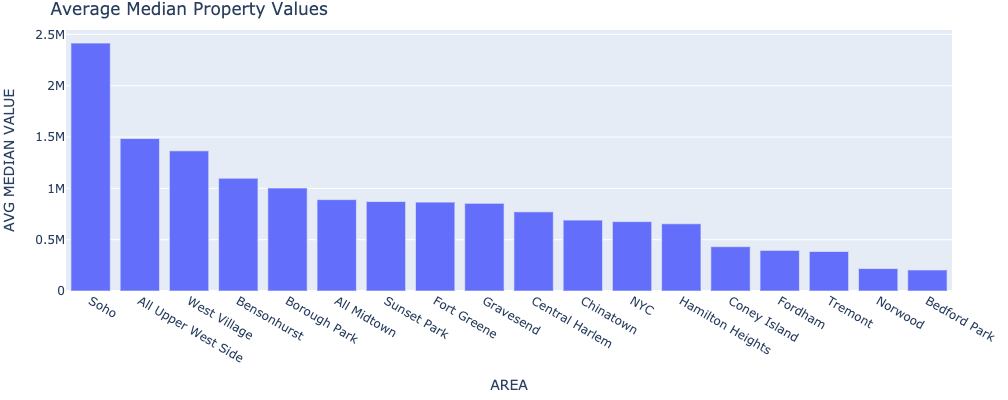

In [27]:
fig = px.bar(Median_avg,x='AREA',y='AVG MEDIAN VALUE',title = 'Average Median Property Values',
            height=400, width=750)
fig.update_layout(
    margin=dict(l=10, r=10, t=30, b=20),
    paper_bgcolor="White")

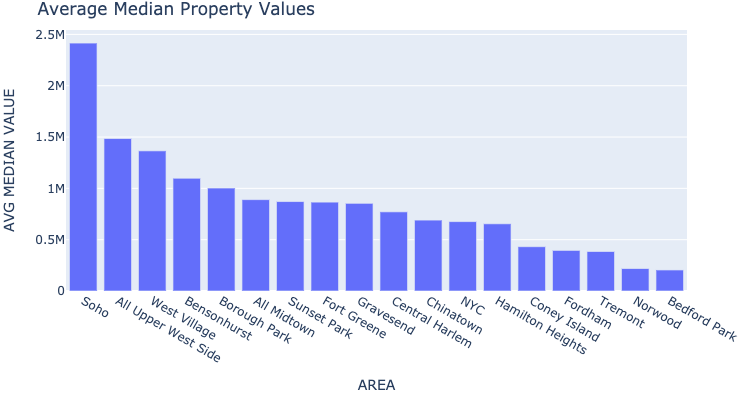

It looks like the area with the highest average median property value is in SoHo and the least is in Bedford Park. We also see an `AREA` named `NYC`, which is the average median property value across all of NYC. 

### MTA Turnstile 

Now I will start cleaning the MTA turnstile data. Let's look at the first few rows again.

In [28]:
mta_df.head()

C/A  UNIT       SCP          STATION  LINENAME DIVISION        DATE  \
0  A022  R022  01-00-00  34 ST-HERALD SQ  BDFMNQRW      BMT  06/20/2020   
1  A022  R022  01-00-00  34 ST-HERALD SQ  BDFMNQRW      BMT  06/20/2020   
2  A022  R022  01-00-00  34 ST-HERALD SQ  BDFMNQRW      BMT  06/20/2020   
3  A022  R022  01-00-00  34 ST-HERALD SQ  BDFMNQRW      BMT  06/20/2020   
4  A022  R022  01-00-00  34 ST-HERALD SQ  BDFMNQRW      BMT  06/20/2020   

       TIME     DESC   ENTRIES     EXITS  
0  00:00:00  REGULAR  28511258  11968853  
1  04:00:00  REGULAR  28511260  11968859  
2  08:00:00  REGULAR  28511262  11968888  
3  12:00:00  REGULAR  28511264  11968926  
4  16:00:00  REGULAR  28511265  11968970

Taking a quick glance, there are multiple entries for each station that are 4 hours apart. Looks like each row represents a specific turnstile which are identified by `C/A`, `UNIT`, `SCP`, and `STATION` columns. The `ENTRIES` column represents cumulative entries at that point in time.

In [29]:
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585842 entries, 0 to 585841
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   C/A       585842 non-null  object
 1   UNIT      585842 non-null  object
 2   SCP       585842 non-null  object
 3   STATION   585842 non-null  object
 4   LINENAME  585842 non-null  object
 5   DIVISION  585842 non-null  object
 6   DATE      585842 non-null  object
 7   TIME      585842 non-null  object
 8   DESC      585842 non-null  object
 9   ENTRIES   585842 non-null  int64 
 10  EXITS     585842 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 49.2+ MB


Our `DATE` and `TIME` columns are listed as `object` however we want them as `datetime`, so I will combine the two columns together into one.


I will also be converting the `DATE` column into `datetime` later on (which I will show and explain why later).

In [30]:
mta_df["DATE_TIME"] = pd.to_datetime(mta_df['DATE'] + " " + mta_df['TIME'], format="%m/%d/%Y %H:%M:%S")

In [31]:
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585842 entries, 0 to 585841
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   C/A        585842 non-null  object        
 1   UNIT       585842 non-null  object        
 2   SCP        585842 non-null  object        
 3   STATION    585842 non-null  object        
 4   LINENAME   585842 non-null  object        
 5   DIVISION   585842 non-null  object        
 6   DATE       585842 non-null  object        
 7   TIME       585842 non-null  object        
 8   DESC       585842 non-null  object        
 9   ENTRIES    585842 non-null  int64         
 10  EXITS      585842 non-null  int64         
 11  DATE_TIME  585842 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 53.6+ MB


In [32]:
mta_df.shape

(585842, 12)

Now before we start doing anything else, I will drop any duplicated rows in the DataFrame. To do so, I will group by `C/A`, `UNIT`, `SCP`, `STATION`, and `DATE_TIME` as they are unique to each turnstiles. 

In [33]:
mta_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=True)
mta_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [34]:
mta_df.shape

(585842, 12)

Looks like we did not have any duplicated rows. Cool. Now I will drop columns that we will not be needing.

In [35]:
mta_df.drop(['DIVISION','DESC'], axis=1, inplace=True)

Since I am interested in how many passengers went through each station at the end of each day I will be taking the last entry for each unique station.


In order to do this I will group by `C/A`, `UNIT`, `SCP`, `STATION`, and `DATE` instead of `DATE_TIME`. This is why I made `DATE` into a `datetime` object. As I will show below, our earliest date `12/31/2019` was pushed all the way to the bottom! This will become a problem because when I take the difference from the previous date entries, `01/01/2020` will NOT have a value!

In [36]:
mta_daily_date_error = mta_df.groupby(["C/A", "UNIT", "SCP", "STATION",'DATE'],as_index=False).ENTRIES.last()

In [37]:
mta_daily_date_error

C/A  UNIT       SCP          STATION        DATE    ENTRIES
0      A022  R022  01-00-00  34 ST-HERALD SQ  01/01/2020   28195483
1      A022  R022  01-00-00  34 ST-HERALD SQ  01/02/2020   28201456
2      A022  R022  01-00-00  34 ST-HERALD SQ  01/03/2020   28206545
3      A022  R022  01-00-00  34 ST-HERALD SQ  01/04/2020   28209846
4      A022  R022  01-00-00  34 ST-HERALD SQ  01/05/2020   28212733
...     ...   ...       ...              ...         ...        ...
97212  R612  R057  01-05-01   ATL AV-BARCLAY  06/26/2020  117440512
97213  R612  R057  01-05-01   ATL AV-BARCLAY  12/28/2019  117440512
97214  R612  R057  01-05-01   ATL AV-BARCLAY  12/29/2019  117440512
97215  R612  R057  01-05-01   ATL AV-BARCLAY  12/30/2019  117440512
97216  R612  R057  01-05-01   ATL AV-BARCLAY  12/31/2019  117440512

[97217 rows x 6 columns]

In [38]:
mta_daily_date_error[["PREV_DATE", "PREV_ENTRIES"]] = (mta_daily_date_error.groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]].shift(1))

In [39]:
mta_daily_date_error.head()

C/A  UNIT       SCP          STATION        DATE   ENTRIES   PREV_DATE  \
0  A022  R022  01-00-00  34 ST-HERALD SQ  01/01/2020  28195483         NaN   
1  A022  R022  01-00-00  34 ST-HERALD SQ  01/02/2020  28201456  01/01/2020   
2  A022  R022  01-00-00  34 ST-HERALD SQ  01/03/2020  28206545  01/02/2020   
3  A022  R022  01-00-00  34 ST-HERALD SQ  01/04/2020  28209846  01/03/2020   
4  A022  R022  01-00-00  34 ST-HERALD SQ  01/05/2020  28212733  01/04/2020   

   PREV_ENTRIES  
0           NaN  
1    28195483.0  
2    28201456.0  
3    28206545.0  
4    28209846.0

See here, `01/01/2020` has a `NaN` even though the previous date `12/31/2019` is in the data set. Let's fix that.

In [40]:
mta_df['DATE']= pd.to_datetime(mta_df['DATE'],format='%m/%d/%Y')

In [41]:
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585842 entries, 562808 to 22476
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   C/A        585842 non-null  object        
 1   UNIT       585842 non-null  object        
 2   SCP        585842 non-null  object        
 3   STATION    585842 non-null  object        
 4   LINENAME   585842 non-null  object        
 5   DATE       585842 non-null  datetime64[ns]
 6   TIME       585842 non-null  object        
 7   ENTRIES    585842 non-null  int64         
 8   EXITS      585842 non-null  int64         
 9   DATE_TIME  585842 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 49.2+ MB


In [42]:
mta_daily = mta_df.groupby(["C/A", "UNIT", "SCP", "STATION",'DATE'],as_index=False).ENTRIES.last()

In [43]:
mta_daily.head()

C/A  UNIT       SCP          STATION       DATE   ENTRIES
0  A022  R022  01-00-00  34 ST-HERALD SQ 2019-12-28  28176536
1  A022  R022  01-00-00  34 ST-HERALD SQ 2019-12-29  28180700
2  A022  R022  01-00-00  34 ST-HERALD SQ 2019-12-30  28186124
3  A022  R022  01-00-00  34 ST-HERALD SQ 2019-12-31  28191658
4  A022  R022  01-00-00  34 ST-HERALD SQ 2020-01-01  28195483

Much better! Now the earliest date is now on top. Now we can use our `.shift` function at ease and see if our values crossed over into the new columns.

In [44]:
mta_daily[["PREV_DATE", "PREV_ENTRIES"]] = (mta_daily.groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]].shift(1))

In [45]:
mta_daily.head()

C/A  UNIT       SCP          STATION       DATE   ENTRIES  PREV_DATE  \
0  A022  R022  01-00-00  34 ST-HERALD SQ 2019-12-28  28176536        NaT   
1  A022  R022  01-00-00  34 ST-HERALD SQ 2019-12-29  28180700 2019-12-28   
2  A022  R022  01-00-00  34 ST-HERALD SQ 2019-12-30  28186124 2019-12-29   
3  A022  R022  01-00-00  34 ST-HERALD SQ 2019-12-31  28191658 2019-12-30   
4  A022  R022  01-00-00  34 ST-HERALD SQ 2020-01-01  28195483 2019-12-31   

   PREV_ENTRIES  
0           NaN  
1    28176536.0  
2    28180700.0  
3    28186124.0  
4    28191658.0

We won't be needing our `PREV_DATE` column now so let's drop it and let's take a look at our statistical values for the entries.

In [46]:
mta_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [47]:
(mta_daily["ENTRIES"] - mta_daily["PREV_ENTRIES"]).describe()

count    9.667000e+04
mean     1.201092e+04
std      9.524171e+06
min     -1.254419e+09
25%      4.800000e+01
50%      1.870000e+02
75%      7.290000e+02
max      1.621027e+09
dtype: float64

Something is wrong.
- We have a negative `minimum` value.
- Our `maximum` value is over 1 billion. 

Let's dive deeper into the problem.

How many rows are there where the `PREV_ENTRIES` is larger than `ENTRIES`?

In [48]:
(mta_daily[mta_daily["ENTRIES"] < mta_daily["PREV_ENTRIES"]]).shape

(1131, 8)

In [49]:
mta_daily[mta_daily["ENTRIES"] < mta_daily["PREV_ENTRIES"]].head()

C/A  UNIT       SCP          STATION       DATE     ENTRIES  PREV_DATE  \
1821  A025  R023  01-03-01  34 ST-HERALD SQ 2019-12-29  1237630287 2019-12-28   
1822  A025  R023  01-03-01  34 ST-HERALD SQ 2019-12-30  1237626538 2019-12-29   
1823  A025  R023  01-03-01  34 ST-HERALD SQ 2019-12-31  1237623395 2019-12-30   
1824  A025  R023  01-03-01  34 ST-HERALD SQ 2020-01-01  1237621234 2019-12-31   
1825  A025  R023  01-03-01  34 ST-HERALD SQ 2020-01-02  1237617626 2020-01-01   

      PREV_ENTRIES  
1821  1.237633e+09  
1822  1.237630e+09  
1823  1.237627e+09  
1824  1.237623e+09  
1825  1.237621e+09

Yikes. How could there be over a billion `PREV_ENTRIES`. To fix this problem, we will deal with reversed counters and take into consideration of the turnstiles resetting after hitting a certain number of entries.

In [50]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    
    if counter < 0:
        counter = -counter  
        
    if counter > max_counter:
        print(f'entries: {row["ENTRIES"]} <-- {row["PREV_ENTRIES"]}')
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        
    if counter > max_counter:
        return 0
    
    return counter

mta_daily["DAILY_ENTRIES"] = mta_daily.apply(get_daily_counts, axis=1, max_counter=10000)

entries: 459077 <-- 85175465.0
entries: 36 <-- 5675074.0
entries: 34 <-- 999938.0
entries: 25 <-- 8800439.0
entries: 86 <-- 8360145.0
entries: 1062 <-- 2302008.0
entries: 95 <-- 2407240.0
entries: 395233 <-- 2064683.0
entries: 2169 <-- 6567669.0
entries: 2010 <-- 22737699.0
entries: 383 <-- 6871938.0
entries: 1627393907 <-- 6366854.0
entries: 1880 <-- 139884.0
entries: 56 <-- 499312.0
entries: 203 <-- 1408008.0
entries: 154 <-- 235111205.0
entries: 12 <-- 1098377.0
entries: 1384 <-- 21914748.0
entries: 3026 <-- 16604.0
entries: 1224795285 <-- 6215.0
entries: 1224793988 <-- 1224961731.0
entries: 57 <-- 1224795434.0
entries: 30 <-- 10444603.0
entries: 589827 <-- 550506.0
entries: 589914 <-- 605983.0
entries: 525226 <-- 602147.0
entries: 1440 <-- 31746.0
entries: 1761 <-- 9753069.0
entries: 30 <-- 112797.0
entries: 872 <-- 12445406.0
entries: 2108 <-- 16347682.0
entries: 724 <-- 6567565.0
entries: 1254418451 <-- 28554762.0
entries: 2981 <-- 1254422418.0
entries: 880 <-- 26112.0
entries: 2

In [51]:
mta_daily.head()

C/A  UNIT       SCP          STATION       DATE   ENTRIES  PREV_DATE  \
1  A022  R022  01-00-00  34 ST-HERALD SQ 2019-12-29  28180700 2019-12-28   
2  A022  R022  01-00-00  34 ST-HERALD SQ 2019-12-30  28186124 2019-12-29   
3  A022  R022  01-00-00  34 ST-HERALD SQ 2019-12-31  28191658 2019-12-30   
4  A022  R022  01-00-00  34 ST-HERALD SQ 2020-01-01  28195483 2019-12-31   
5  A022  R022  01-00-00  34 ST-HERALD SQ 2020-01-02  28201456 2020-01-01   

   PREV_ENTRIES  DAILY_ENTRIES  
1    28176536.0         4164.0  
2    28180700.0         5424.0  
3    28186124.0         5534.0  
4    28191658.0         3825.0  
5    28195483.0         5973.0

In [52]:
mta_daily['DAILY_ENTRIES'].describe()

count    96670.000000
mean       569.840881
std        840.583403
min          0.000000
25%         53.000000
50%        195.000000
75%        748.000000
max       9193.000000
Name: DAILY_ENTRIES, dtype: float64

Much better! We got rid of our negative `minimum` value and our `maximum` value isn't over 1 billion.

Now let's combine turnstiles that fall within the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstiles -- same value for the `C/A`, `UNIT` and `STATION` columns, different values for the `SCP` column.

In [53]:
station_daily = mta_daily.groupby(['C/A','UNIT','STATION','DATE'])[['DAILY_ENTRIES']].sum().reset_index()

In [54]:
station_daily

C/A  UNIT          STATION       DATE  DAILY_ENTRIES
0      A022  R022  34 ST-HERALD SQ 2019-12-29        12085.0
1      A022  R022  34 ST-HERALD SQ 2019-12-30        17244.0
2      A022  R022  34 ST-HERALD SQ 2019-12-31        16853.0
3      A022  R022  34 ST-HERALD SQ 2020-01-01        11005.0
4      A022  R022  34 ST-HERALD SQ 2020-01-02        18859.0
...     ...   ...              ...        ...            ...
12838  R612  R057   ATL AV-BARCLAY 2020-06-22         1517.0
12839  R612  R057   ATL AV-BARCLAY 2020-06-23         1693.0
12840  R612  R057   ATL AV-BARCLAY 2020-06-24         1869.0
12841  R612  R057   ATL AV-BARCLAY 2020-06-25         1795.0
12842  R612  R057   ATL AV-BARCLAY 2020-06-26         2041.0

[12843 rows x 5 columns]

Then I wil come up with daily time series for each `STATION`, by adding up the daily entries for all the turnstiles in each station.

In [55]:
daily_total_entries = station_daily.groupby(['STATION','DATE'])[['DAILY_ENTRIES']].sum().reset_index()

Let's take a look at the different `STATION`.

In [56]:
daily_total_entries['STATION'].unique()

array(['125 ST', '145 ST', '155 ST', '161/YANKEE STAD', '167 ST',
       '170 ST', '174-175 STS', '18 AV', '182-183 STS', '20 AV', '25 AV',
       '34 ST-HERALD SQ', '36 ST', '4 AV-9 ST', '42 ST-BRYANT PK',
       '47-50 STS ROCK', '4AV-9 ST', '5 AVE', '50 ST', '55 ST',
       '59 ST COLUMBUS', '7 AV', '71 ST', '79 ST', '9 AV',
       'ATL AV-BARCLAY', "B'WAY-LAFAYETTE", 'BAY 50 ST', 'BAY PKWY',
       'BEDFORD PK BLVD', 'BLEECKER ST', 'CONEY IS-STILLW', 'DEKALB AV',
       'FORDHAM RD', 'FT HAMILTON PKY', 'GRAND ST', 'KINGSBRIDGE RD',
       'NEW UTRECHT AV', 'NORWOOD 205 ST', 'TREMONT AV', 'W 4 ST-WASH SQ'],
      dtype=object)

Interestingly enough, there are stations where the D line runs [full-time, part-time, and night-service](https://new.mta.info/). However, referring back to the MTA website the data set does not have all the part-time stations and/or night-service stations, so for the purpose of this project I will only look at the stations where the D line stops at full-time.

In [57]:
not_ft_stations = [
'155 ST', 
'161/YANKEE STAD', 
'167 ST',
'170 ST', 
'174-175 STS', 
'182-183 STS', 
'4 AV-9 ST', 
'4AV-9 ST', 
'5 AVE',
'FORDHAM RD', 
'TREMONT AV',
'DEKALB AV',
'BLEECKER ST'
]

In [58]:
daily_total_entries.set_index(['STATION'], inplace=True)

In [59]:
daily_total_entries.drop(not_ft_stations, axis=0, inplace=True)

In [60]:
daily_total_entries.reset_index(inplace=True)

In [61]:
len(daily_total_entries['STATION'].unique())

28

Let's look at the weekly number of entries.

In [62]:
daily_total_entries['WEEK_OF_YEAR'] = pd.to_datetime(daily_total_entries['DATE']).dt.isocalendar().week

In [63]:
daily_total_entries.head()

STATION       DATE  DAILY_ENTRIES  WEEK_OF_YEAR
0  125 ST 2019-12-29        18323.0            52
1  125 ST 2019-12-30        19991.0             1
2  125 ST 2019-12-31        22678.0             1
3  125 ST 2020-01-01        12081.0             1
4  125 ST 2020-01-02        24834.0             1

In [64]:
daily_total_entries[daily_total_entries['WEEK_OF_YEAR']==52]

STATION       DATE  DAILY_ENTRIES  WEEK_OF_YEAR
0              125 ST 2019-12-29        18323.0            52
181            145 ST 2019-12-29        13346.0            52
362             18 AV 2019-12-29         3407.0            52
543             20 AV 2019-12-29         2848.0            52
724             25 AV 2019-12-29         2342.0            52
905   34 ST-HERALD SQ 2019-12-29        75149.0            52
1086            36 ST 2019-12-29         6910.0            52
1267  42 ST-BRYANT PK 2019-12-29        22398.0            52
1448   47-50 STS ROCK 2019-12-29        41130.0            52
1629            50 ST 2019-12-29         1649.0            52
1810            55 ST 2019-12-29         1118.0            52
1991   59 ST COLUMBUS 2019-12-29        36865.0            52
2172             7 AV 2019-12-29        10882.0            52
2353            71 ST 2019-12-29         2782.0            52
2534            79 ST 2019-12-29         3546.0            52
2715             9 AV 2019-12-29         3095.0            52
2896   ATL AV-BARCLAY 2019-12-29        19761.0            52
3077  B'WAY-LAFAYETTE 2019-12-29        14507.0            52
3255        BAY 50 ST 2019-12-29         1301.0            52
3436         BAY PKWY 2019-12-29         4315.0            52
3617  BEDFORD PK BLVD 2019-12-29         3109.0            52
3798  CONEY IS-STILLW 2019-12-29         6295.0            52
3979  FT HAMILTON PKY 2019-12-29         1823.0            52
4160         GRAND ST 2019-12-29        20337.0            52
4341   KINGSBRIDGE RD 2019-12-29         3768.0            52
4522   NEW UTRECHT AV 2019-12-29         2443.0            52
4703   NORWOOD 205 ST 2019-12-29         4350.0            52
4884   W 4 ST-WASH SQ 2019-12-29        29527.0            52

It looks like the last week of December 2019 only contains one day. So I will drop that week.

In [65]:
dropping_52 = daily_total_entries.set_index('WEEK_OF_YEAR')

In [66]:
dropping_52.drop(52,inplace=True)

In [67]:
daily_total_entries = dropping_52.reset_index()

In [68]:
daily_total_entries

WEEK_OF_YEAR         STATION       DATE  DAILY_ENTRIES
0                1          125 ST 2019-12-30        19991.0
1                1          125 ST 2019-12-31        22678.0
2                1          125 ST 2020-01-01        12081.0
3                1          125 ST 2020-01-02        24834.0
4                1          125 ST 2020-01-03        25414.0
...            ...             ...        ...            ...
5032            26  W 4 ST-WASH SQ 2020-06-22         4670.0
5033            26  W 4 ST-WASH SQ 2020-06-23         4956.0
5034            26  W 4 ST-WASH SQ 2020-06-24         4997.0
5035            26  W 4 ST-WASH SQ 2020-06-25         5289.0
5036            26  W 4 ST-WASH SQ 2020-06-26         5621.0

[5037 rows x 4 columns]

Now I will group each `STATION` by the the `WEEK_OF_YEAR` to get the sum of the weekly entries.

In [69]:
weekly_total_entries = daily_total_entries.groupby(['WEEK_OF_YEAR','STATION']).sum('DAILY_ENTRIES')

In [70]:
weekly_total_entries.reset_index(inplace=True)

In [71]:
weekly_total_entries.rename(columns={'DAILY_ENTRIES':'WEEKLY_ENTRIES'}, inplace=True)

In [72]:
weekly_total_entries.tail()

WEEK_OF_YEAR         STATION  WEEKLY_ENTRIES
723            26        GRAND ST         23704.0
724            26  KINGSBRIDGE RD         11949.0
725            26  NEW UTRECHT AV          7182.0
726            26  NORWOOD 205 ST         14894.0
727            26  W 4 ST-WASH SQ         25533.0

## MTA Visualizations 
I want to see each individual station and their ridership levels weekly throughout the 6 months. Let's plot it.

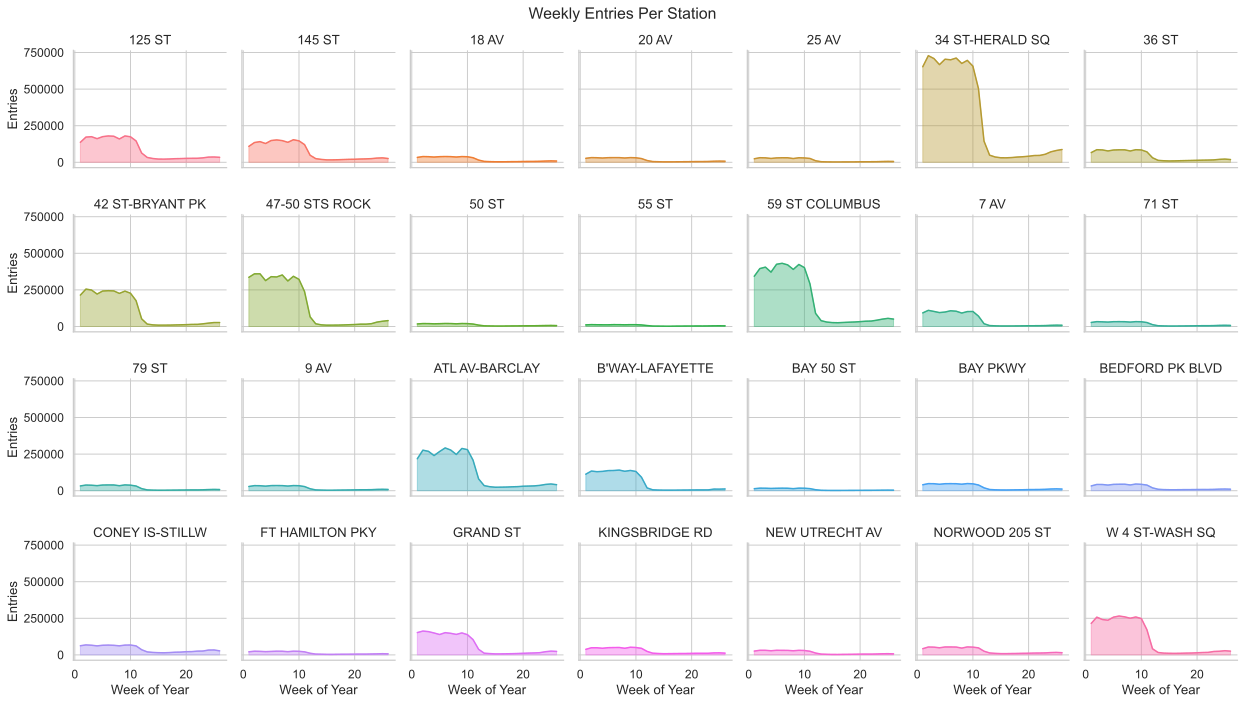

In [73]:
g = sns.FacetGrid(weekly_total_entries, col='STATION', hue='STATION', col_wrap=7, height=2.5, aspect=1)
g = g.map(plt.plot, 'WEEK_OF_YEAR', 'WEEKLY_ENTRIES')
g = g.map(plt.fill_between, 'WEEK_OF_YEAR', 'WEEKLY_ENTRIES', alpha=0.4).set_titles('{col_name} STATION')
g = g.set_titles('{col_name}')
g = g.set_axis_labels('Week of Year','Entries')
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Weekly Entries Per Station')
plt.subplots_adjust(hspace=0.4, wspace=0.1)

It looks like the plot shape is almost similar for all the stations! Herald Square has a lot of entries, that is given since there are many lines that passes through it. 

Let's plot the total ridership levels for all the stations for each week.

In [74]:
weekly_total_entries = weekly_total_entries.groupby(['WEEK_OF_YEAR']).sum('WEEKLY_ENTRIES')

In [75]:
weekly_total_entries.reset_index(inplace=True)

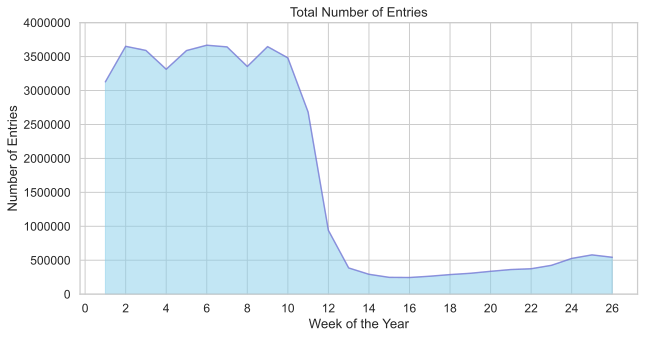

In [76]:
plt.figure(figsize=(10,5))
plt.fill_between(weekly_total_entries['WEEK_OF_YEAR'], weekly_total_entries['WEEKLY_ENTRIES'], color='skyblue', alpha=0.5)
plt.plot(weekly_total_entries['WEEK_OF_YEAR'], weekly_total_entries['WEEKLY_ENTRIES'], color="Slateblue", alpha=0.6)
plt.xlabel('Week of the Year')
plt.ylabel('Number of Entries')
plt.ylim(0,4000000)
plt.title('Total Number of Entries')
plt.locator_params(axis='x', nbins=26)
plt.ticklabel_format(axis="y", style="plain");

We can see that there was a drastic decrease in ridership by 12th week 2020. Comparing to each individual station, it looks like they all have generally the same shape.

Since I am dealing with pre and present covid I will break up the dataframe accordingly. The pandemic hit NYC in March of 2020, Governmor Cuomo implemented a citywide PAUSE order on March 22 I will group all the weeks including March 22 as pre-covid and everything after March 22 in present covid.

First I will calculate the overall percent decrease from all the station's weekly average riderships between the two time periods.

In [77]:
pre_covid_weekly_avg = weekly_total_entries['WEEKLY_ENTRIES'].iloc[:11].mean()

In [78]:
present_covid_weekly_avg = weekly_total_entries['WEEKLY_ENTRIES'].iloc[12:].mean()

In [79]:
overall_change = round(((present_covid_weekly_avg - pre_covid_weekly_avg)/ pre_covid_weekly_avg)* 100,3)
overall_change

-89.203

What an astronomical decrease in ridership! This makes me think about how much profit the MTA lost. But we have to understand that this is ONLY for the D line.

I want to find the number of weekly entries for each `WEEK_OF_YEAR` for each `STATION`.

In [80]:
stations = daily_total_entries.groupby(['WEEK_OF_YEAR','STATION'], as_index=False).sum('DAILY_ENTRIES')

In [81]:
stations.rename(columns={'DAILY_ENTRIES':'WEEKLY_ENTRIES'},inplace=True)

Now to split our time periods to pre-COVID and present COVID. Then I will find the mean of all the `WEEKLY_ENTRIES` for each `STATION`.

In [82]:
pre_covid_stations = stations[:360]

In [83]:
pre_covid_stations

WEEK_OF_YEAR          STATION  WEEKLY_ENTRIES
0               1           125 ST        136613.0
1               1           145 ST        108829.0
2               1            18 AV         33399.0
3               1            20 AV         27173.0
4               1            25 AV         24113.0
..            ...              ...             ...
355            13         BAY PKWY          8245.0
356            13  BEDFORD PK BLVD          9738.0
357            13  CONEY IS-STILLW         20385.0
358            13  FT HAMILTON PKY          5566.0
359            13         GRAND ST         11636.0

[360 rows x 3 columns]

In [84]:
pre_covid_stations.set_index('STATION')

WEEK_OF_YEAR  WEEKLY_ENTRIES
STATION                                      
125 ST                      1        136613.0
145 ST                      1        108829.0
18 AV                       1         33399.0
20 AV                       1         27173.0
25 AV                       1         24113.0
...                       ...             ...
BAY PKWY                   13          8245.0
BEDFORD PK BLVD            13          9738.0
CONEY IS-STILLW            13         20385.0
FT HAMILTON PKY            13          5566.0
GRAND ST                   13         11636.0

[360 rows x 2 columns]

In [85]:
pre_covid = pre_covid_stations.groupby(['STATION']).mean('WEEKLY_ENTRIES').round(2)

In [86]:
pre_covid.drop('WEEK_OF_YEAR',axis=1,inplace=True)

In [87]:
pre_covid

WEEKLY_ENTRIES
STATION                        
125 ST                148757.54
145 ST                122577.15
18 AV                  32991.31
20 AV                  26947.69
25 AV                  25485.69
34 ST-HERALD SQ       584462.31
36 ST                  71694.00
42 ST-BRYANT PK       200791.00
47-50 STS ROCK        284487.23
50 ST                  17299.85
55 ST                  10832.23
59 ST COLUMBUS        340747.69
7 AV                   84932.62
71 ST                  27824.38
79 ST                  32498.77
9 AV                   29255.15
ATL AV-BARCLAY        229333.38
B'WAY-LAFAYETTE       111010.54
BAY 50 ST              14254.54
BAY PKWY               40804.54
BEDFORD PK BLVD        37153.92
CONEY IS-STILLW        59183.77
FT HAMILTON PKY        21209.77
GRAND ST              126466.54
KINGSBRIDGE RD         45599.67
NEW UTRECHT AV         28052.92
NORWOOD 205 ST         48846.67
W 4 ST-WASH SQ        225458.75

In [88]:
present_covid_stations = stations[360:]

In [89]:
present_covid_stations.set_index('STATION')

WEEK_OF_YEAR  WEEKLY_ENTRIES
STATION                                     
KINGSBRIDGE RD            13         11807.0
NEW UTRECHT AV            13          5455.0
NORWOOD 205 ST            13         13285.0
W 4 ST-WASH SQ            13         16384.0
125 ST                    14         25869.0
...                      ...             ...
GRAND ST                  26         23704.0
KINGSBRIDGE RD            26         11949.0
NEW UTRECHT AV            26          7182.0
NORWOOD 205 ST            26         14894.0
W 4 ST-WASH SQ            26         25533.0

[368 rows x 2 columns]

In [90]:
present_covid = present_covid_stations.groupby(['STATION']).mean('WEEKLY_ENTRIES').round(2)

In [91]:
present_covid.drop('WEEK_OF_YEAR',axis=1,inplace=True)

In [92]:
present_covid

WEEKLY_ENTRIES
STATION                        
125 ST                 27633.46
145 ST                 21952.62
18 AV                   5857.31
20 AV                   4982.62
25 AV                   3791.31
34 ST-HERALD SQ        48698.85
36 ST                  14257.00
42 ST-BRYANT PK        15210.08
47-50 STS ROCK         17870.46
50 ST                   4866.54
55 ST                   3341.54
59 ST COLUMBUS         36616.85
7 AV                    5535.54
71 ST                   5218.46
79 ST                   5302.38
9 AV                    5903.46
ATL AV-BARCLAY         31876.92
B'WAY-LAFAYETTE         6072.46
BAY 50 ST               2589.77
BAY PKWY                7891.31
BEDFORD PK BLVD         8321.69
CONEY IS-STILLW        22254.46
FT HAMILTON PKY         5407.23
GRAND ST               13148.46
KINGSBRIDGE RD         10679.21
NEW UTRECHT AV          5201.64
NORWOOD 205 ST         12089.07
W 4 ST-WASH SQ         16846.57

To exam `STATION` more closely, I want to see the percent change for each individual stations.

In [93]:
change = ((present_covid['WEEKLY_ENTRIES'] - pre_covid['WEEKLY_ENTRIES'] )/ pre_covid['WEEKLY_ENTRIES']) * -100

In [94]:
difference = change.to_frame('Percent Decrease')

In [95]:
difference.reset_index(inplace=True)

In [96]:
difference.sort_values('Percent Decrease')

STATION  Percent Decrease
21  CONEY IS-STILLW         62.397698
10            55 ST         69.151874
9             50 ST         71.869467
22  FT HAMILTON PKY         74.505947
26   NORWOOD 205 ST         75.250984
24   KINGSBRIDGE RD         76.580510
20  BEDFORD PK BLVD         77.602121
15             9 AV         79.820784
6             36 ST         80.114096
19         BAY PKWY         80.660706
13            71 ST         81.245009
0            125 ST         81.423826
25   NEW UTRECHT AV         81.457759
3             20 AV         81.510029
18        BAY 50 ST         81.831964
1            145 ST         82.090773
2             18 AV         82.245901
14            79 ST         83.684367
4             25 AV         85.123769
16   ATL AV-BARCLAY         86.100183
11   59 ST COLUMBUS         89.253970
23         GRAND ST         89.603210
5   34 ST-HERALD SQ         91.667752
7   42 ST-BRYANT PK         92.424919
27   W 4 ST-WASH SQ         92.527870
12             7 AV         93.482433
8    47-50 STS ROCK         93.718361
17  B'WAY-LAFAYETTE         94.529835

Now that we have our percent difference for each `STATION` between the two time periods. I will map each `STATION` to it's corresponding `AREA`.

In [97]:
#full-time stations only
station_neighborhoods = {
    'NORWOOD 205 ST':'Norwood',
    'BEDFORD PK BLVD':'Bedford Park',
    'KINGSBRIDGE RD':'Bedford Park',
    'FORDHAM RD':'Fordham', 
    'TREMONT AV':'Tremont',
    '145 ST':'Hamilton Heights',
    '125 ST':'Central Harlem',
    '59 ST COLUMBUS':'All Upper West Side',
    '7 AV':'All Midtown',
    '47-50 STS ROCK':'All Midtown',
    '42 ST-BRYANT PK':'All Midtown',
    '34 ST-HERALD SQ':'All Midtown', 
    'W 4 ST-WASH SQ':'West Village',
    "B'WAY-LAFAYETTE":'Soho',
    'GRAND ST':'Chinatown',
    'ATL AV-BARCLAY':'Fort Greene',
    '36 ST':'Sunset Park', 
    '9 AV':'Sunset Park',
    'FT HAMILTON PKY':'Sunset Park', 
    '50 ST':'Borough Park', 
    '55 ST':'Borough Park',
    'NEW UTRECHT AV':'Borough Park', 
    '71 ST':'Bensonhurst', 
    '79 ST':'Bensonhurst',
    '18 AV':'Bensonhurst',
    '20 AV':'Bensonhurst', 
    'BAY PKWY':'Bensonhurst',
    '25 AV':'Bensonhurst',
    'BAY 50 ST':'Gravesend',
    'CONEY IS-STILLW':'Coney Island'
}


In [98]:
difference['AREA'] = difference['STATION'].map(station_neighborhoods)

We have multiple stations for each `AREA`. Let's take the average percent decrease for the areas with more than one `STATION`.

In [99]:
grouped = difference.groupby(['AREA']).mean('Percent Decrease')

In [100]:
area_difference = pd.merge(grouped,Median_avg,on='AREA')

In [101]:
area_difference

AREA  Percent Decrease  AVG MEDIAN VALUE
0           All Midtown         92.823367            890250
1   All Upper West Side         89.253970           1485625
2          Bedford Park         77.091316            205100
3           Bensonhurst         82.411630           1098750
4          Borough Park         74.159700           1003291
5        Central Harlem         81.423826            771449
6             Chinatown         89.603210            691000
7          Coney Island         62.397698            431750
8           Fort Greene         86.100183            866100
9             Gravesend         81.831964            854467
10     Hamilton Heights         82.090773            655000
11              Norwood         75.250984            219000
12                 Soho         94.529835           2415697
13          Sunset Park         78.146942            871625
14         West Village         92.527870           1365520

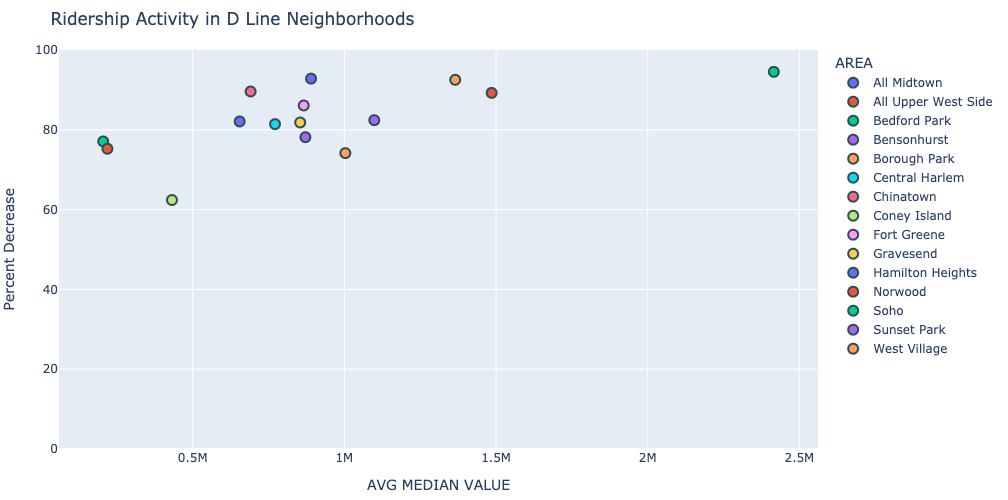

In [102]:
fig = px.scatter(area_difference, x='AVG MEDIAN VALUE', y = 'Percent Decrease',
                 title = 'Ridership Activity in D Line Neighborhoods', color='AREA',
                height=500, width=750)
fig.update_traces(marker=dict(size=10,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    margin=dict(l=10, r=10, t=50, b=20),
    paper_bgcolor="White")
fig.update_yaxes(range=[0,100])






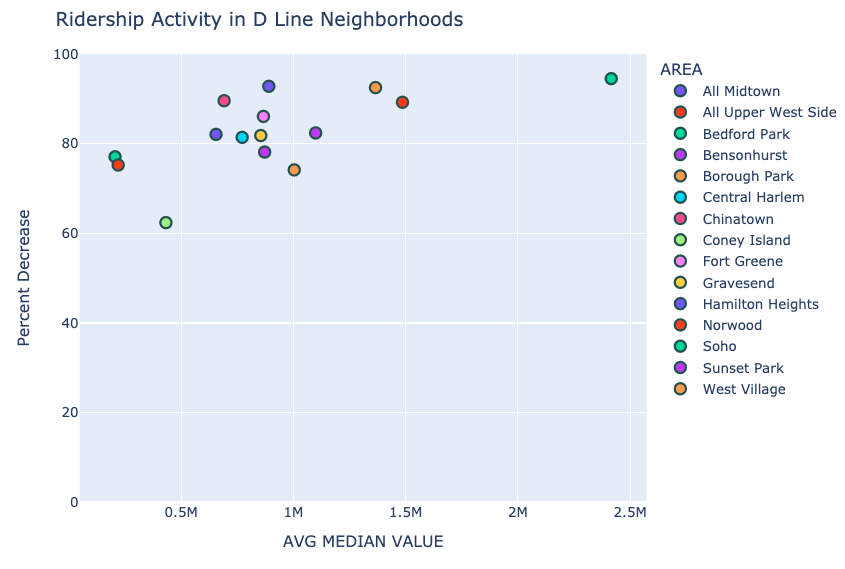







In [103]:
area_difference.corr()

Percent Decrease  AVG MEDIAN VALUE
Percent Decrease          1.000000          0.648204
AVG MEDIAN VALUE          0.648204          1.000000

There is a positive correlation between `Percent Decrease` and `AVG MEDIAN VALUE`. 

## Understanding Station's Location

In [104]:
location_df.head()

STATION              Line Station_Lat  Station_Long
0           103rd St          8 Avenue   40.796092    -73.961454
1           103rd St  Broadway-7th Ave   40.799446    -73.968379
2           103rd St          Flushing   40.749865    -73.862700
3           103rd St         Lexington     40.7906    -73.947478
4  104th St-102nd St  Broadway Jamaica   40.695178    -73.844330

It looks like `STATION` columns has the names of the station but it does not match our MTA `STATION`. I will clean that. 

In [105]:
def process_st_number(words):
    ordinal = ["st", "nd", "rd", "th"]
    result = ""
    words = words.split(" ")
    
    for word in words:
        if word[0].isdigit():
            for match in ordinal:            
                word = word.replace(match, "")
        
        result = result + " " + word
    # ex. 123rd -> 123
    return result.strip()

def swap_station_name(name):
    # take care of "name (123)" cases
    name = name.replace("(", "- ")
    name = name.replace(")", "")
    # delete ordinal and make it uppercase
    name = process_st_number(name)
    name = name.replace(" - ", "-").upper()
    split = name.split("-")
    
    # cases that have '-' symbol
    if len(split) == 2:
        if (not split[0][0].isdigit()) and (split[1][0].isdigit()):
            return split[1] + "-" + split[0]
        else:
            return split[0] + "-" + split[1]
    # ex. street-123 -> 123-street
    return name

In [106]:
location_df['STATION'] = location_df['STATION'].apply(process_st_number)

In [107]:
location_df['STATION'] = location_df['STATION'].apply(swap_station_name)

In [108]:
location_df.head()

STATION              Line Station_Lat  Station_Long
0           103 ST          8 Avenue   40.796092    -73.961454
1           103 ST  Broadway-7th Ave   40.799446    -73.968379
2           103 ST          Flushing   40.749865    -73.862700
3           103 ST         Lexington     40.7906    -73.947478
4  104 ST-102ND ST  Broadway Jamaica   40.695178    -73.844330

I will not be working with all the stations, I will have to isolate to only the stations I am looking at.

In [109]:
my_stations = ['125 ST','145 ST', '18 AV','20 AV','25 AV','36 ST','47-50 STS ROCKEFELLER CENTER','50 ST','55 ST', '59 ST-COLUMBUS CIRCLE','71 ST', '79 ST','9 AV', 'BAY PARKWAY','KINGSBRIDGE RD',
 'NEW UTRECHT AV','FORT HAMILTON PARKWAY','STILLWELL AV','BEDFORD PARK BLVD','BAY 50 ST','ATLANTIC AV-BARCLAYS CTR','WEST 4 ST','205TH ST-NORWOOD',
 'GRAND ST', 'BROADWAY-LAFAYETTE ST','34 ST', '42 ST','7 AV']

In [110]:
station_location =  pd.DataFrame(my_stations)

In [111]:
station_location.rename(columns={0:'STATION'},inplace=True)

In [112]:
new = pd.merge(station_location,location_df, on='STATION')

In [113]:
new.head()

STATION              Line Station_Lat  Station_Long
0  125 ST          8 Avenue   40.811109    -73.952343
1  125 ST  Broadway-7th Ave   40.815581    -73.958372
2  125 ST             Lenox   40.807754    -73.945495
3  125 ST         Lexington   40.804138    -73.937594
4  145 ST          8 Avenue   40.824783    -73.944216

Looks like there are multiple lines with the same station name. I will drop the ones that are not on the D line and rename the stations to match our MTA station names.

In [114]:
new.drop([1,2,3,5,6,7,9,10,14,17,18,23,27,29,31,32,37,40,43,45,46,48,49,50],inplace=True)

In [115]:
new.set_index('STATION',inplace=True)

In [116]:
new.rename(index={'47-50 STS ROCKEFELLER CENTER':'47-50 STS ROCK','34 ST': '34 ST-HERALD SQ','59 ST-COLUMBUS CIRCLE':'59 ST COLUMBUS',
                  'BAY PARKWAY':'BAY PKWY','FORT HAMILTON PARKWAY':'FT HAMILTON PKY','STILLWELL AV': 'CONEY IS-STILLW','BEDFORD PARK BLVD':'BEDFORD PK BLVD',
                  'ATLANTIC AV-BARCLAYS CTR': 'ATL AV-BARCLAY', 'WEST 4 ST':'W 4 ST-WASH SQ','205TH ST-NORWOOD': 'NORWOOD 205 ST','BROADWAY-LAFAYETTE ST':"B'WAY-LAFAYETTE", 
                  '42 ST': '42 ST-BRYANT PK'},inplace=True)

In [117]:
new.reset_index(inplace=True)

In [118]:
new.head()

STATION      Line Station_Lat  Station_Long
0  125 ST  8 Avenue   40.811109    -73.952343
1  145 ST  8 Avenue   40.824783    -73.944216
2   18 AV  West End   40.607954    -74.001736
3   20 AV  West End   40.604556    -73.998168
4   25 AV  West End   40.597704    -73.986829

In [119]:
station_points = pd.merge(difference,new, on='STATION')

In [120]:
position = station_points.drop(['Percent Decrease','AREA','Line'], axis=1)

I will make a figure for the map.

In [121]:
nycmap = gpd.read_file('/Users/coxiao/Documents/Metis/EDA/Project_EDA/Borough Boundaries/geo_export_60002efb-96ac-4e90-bfaf-85ee8f80f0eb.shp')

In [122]:
df_geo = gpd.GeoDataFrame(position, 
                          geometry = gpd.points_from_xy(position.Station_Long,
                                                        position.Station_Lat))
                                            

In [123]:
df_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   STATION       28 non-null     object  
 1   Station_Lat   28 non-null     object  
 2   Station_Long  28 non-null     float64 
 3   geometry      28 non-null     geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 1.1+ KB


In [124]:
entrieschange = -(present_covid['WEEKLY_ENTRIES'] - pre_covid['WEEKLY_ENTRIES'])

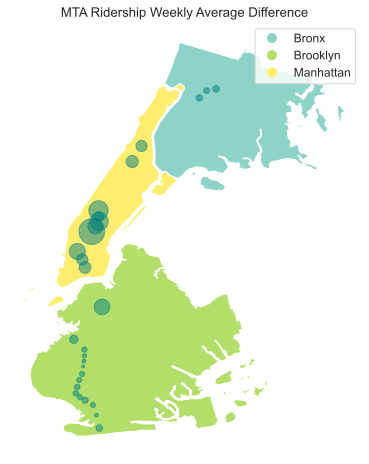

In [125]:
nycmap = nycmap[(nycmap['boro_name'] != 'Staten Island') & (nycmap['boro_name'] != 'Queens')]
fig,ax = plt.subplots(figsize=(8,8))
nycmap.plot(ax=ax, cmap='Set3', column = 'boro_name', legend=True)
df_geo.plot(ax=ax,color='teal', marker='.', 
                markersize = entrieschange/200 , alpha = 1/2)
ax.set_axis_off()
ax.set_title("MTA Ridership Weekly Average Difference");


I removed Staten Island and Queens since D line does not run through those boroughs.
Here is a visual representation of the trail that the D Line passes through everyday. This is not a representation of
percent decrease. This shows the difference between pre-covid weekly average and present covid weekly average for each station.
The Manhattan in general showed a bigger difference in riders weekly average, it could be because it has more foot traffic in that borough.
There's less foot traffic in the stations in lower Brooklyn. Since the stations are so close together in that general area, people have more 
options to which station they want to go.


## Conclusions

It is safe to say that the D line was affected badly. With an overall decrease in 89% ridership from mid March 2020 to June 2020. It would be interesting
to observe other station lines to see their ridership activities and which line was affected the most. In order to more accurately determine how neighborhoods affected MTA ridership, looking into all neighborhoods of NYC and their nearby stations would give us a more effecient perspective on their relationship.

Future projects to dive into:
- Grand St, which is in Chinatown, is a heavily Asian population neighborhood. During the pandemic, there was a lot of fear towards the Asian population as people thought they were infected with COVID-19. As a result, Chinatown lost a lot of tourism. As we are still going through this pandemic, we can look into the ridership level to present day.
- Vaccination started rolling out in January 2021, we can see how it changed ridership levels. Did it increase?
- Instead of median property value, see the relationship between average household income.
